# Constructing The Model

## Imports

In [112]:
import cv2
import IPython.display as ipd
import librosa # Compatible with python 3.10
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional  as F
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms


from PIL import Image
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision.transforms import ToTensor
from torchvision.transforms import v2

## Constants

#### Directories

In [113]:
# Assign paths
base_dir = "dataset"

# Use for-norm dataset
train_dir = os.path.join(base_dir, "for-norm", "for-norm", "training")
test_dir = os.path.join(base_dir, "for-norm", "for-norm", "testing")
val_dir = os.path.join(base_dir, "for-norm", "for-norm", "validation")

# Classified directories
train_dir_fake = os.path.join(train_dir, "fake")
train_dir_real = os.path.join(train_dir, "real")
test_dir_fake = os.path.join(test_dir, "fake")
test_dir_real = os.path.join(test_dir, "real")
val_dir_fake = os.path.join(val_dir, "fake")
val_dir_real = os.path.join(val_dir, "real")

In [114]:
# Check for mistakes
print("Base directory:", base_dir)
print()
print("Train directory:", train_dir)
print("Test directory:", test_dir)
print("Val directory:", val_dir)
print()
print("Train (fake) directory:", train_dir_fake)
print("Train (real) directory:", train_dir_real)
print("Test (fake) directory:", test_dir_fake)
print("Test (real) directory:", test_dir_real)
print("Val (fake) directory:", val_dir_fake)
print("Val (real) directory:", val_dir_real)

Base directory: dataset

Train directory: dataset/for-norm/for-norm/training
Test directory: dataset/for-norm/for-norm/testing
Val directory: dataset/for-norm/for-norm/validation

Train (fake) directory: dataset/for-norm/for-norm/training/fake
Train (real) directory: dataset/for-norm/for-norm/training/real
Test (fake) directory: dataset/for-norm/for-norm/testing/fake
Test (real) directory: dataset/for-norm/for-norm/testing/real
Val (fake) directory: dataset/for-norm/for-norm/validation/fake
Val (real) directory: dataset/for-norm/for-norm/validation/real


#### Other Constants

In [115]:
# Torch seed (for reproducibility purpose)
SEED = 33

BATCH_SIZE = 64
EPOCH = 20
LEARNING_RATE = 0.0001
NUM_WORKERS = 16
PATIENCE = 3

In [116]:
torch.cuda.empty_cache() # Free CUDA cache memory
torch.manual_seed(SEED) # Assign Pytorch seed for reproducibility
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Initiate a CUDA device instance, if exists

In [117]:
# Current model
def get_current_model_path(new_model=False):
    count = 1

    while (True):
        if (os.path.isfile("../../trained_models/audio_custom_model_" + f"{count}" + ".pth") == False):
            if (new_model):
                return "../../trained_models/audio_custom_model_" + f"{count}" + ".pth"
            else:
                return "../../trained_models/audio_custom_model_" + f"{count - 1}" + ".pth"
        else:
            count += 1

## Obtain Data

In [118]:
# Obtain waveform (.wav) audio files
train_fake_audio_path = [os.path.join(train_dir_fake, file) for file in os.listdir(train_dir_fake) if file.endswith(".wav")]
train_real_audio_path = [os.path.join(train_dir_real, file) for file in os.listdir(train_dir_real) if file.endswith(".wav")]

test_fake_audio_path = [os.path.join(test_dir_fake, file) for file in os.listdir(test_dir_fake) if file.endswith(".wav")]
test_real_audio_path = [os.path.join(test_dir_real, file) for file in os.listdir(test_dir_real) if file.endswith(".wav")]

validation_fake_audio_path = [os.path.join(val_dir_fake, file) for file in os.listdir(val_dir_fake) if file.endswith(".wav")]
validation_real_audio_path = [os.path.join(val_dir_real, file) for file in os.listdir(val_dir_real) if file.endswith(".wav")]

In [119]:
# Get training labels
train_labels = []

for i in train_fake_audio_path:
    train_labels.append(0)
for i in train_real_audio_path:
    train_labels.append(1)

# Convert list to Pandas dataframe
train_labels_df = pd.DataFrame({'label':train_labels})

# Get testing labels
val_labels = []

for i in validation_fake_audio_path:
    val_labels.append(0)
for i in validation_real_audio_path:
    val_labels.append(1)

# Convert list to Pandas dataframe
val_labels_df = pd.DataFrame({'label':val_labels})

In [120]:
train_labels_df.head(10)

,label
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [121]:
val_labels_df.head(10)

,label
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [122]:
#  Evaluate the training labels
count = 0

for i in range(len(train_labels)):
    if (train_labels[i] == 0):
        count = count+1

print(train_labels)
print("Number of total labels:", len(train_labels))
print("Number of fake audio samples:", count)
print("Number of real audio samples:", len(train_labels) - count)


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [123]:
#  Evaluate the testing labels
count = 0

for i in range(len(val_labels)):
    if (val_labels[i] == 0):
        count = count+1

print(val_labels)
print("Number of total labels:", len(val_labels))
print("Number of fake audio samples:", count)
print("Number of real audio samples:", len(val_labels) - count)


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [124]:
# Display a random real training sample audio
random_real_training_audio_file = train_real_audio_path[random.randint(0, 333)]
ipd.Audio(random_real_training_audio_file)

In [125]:
# Display a random fake training sample audio
random_fake_training_audio_file = train_fake_audio_path[random.randint(0, 333)]
ipd.Audio(random_fake_training_audio_file)


## Data Preprocessing

In [126]:
# Training
class CustomTrainingAudioDataset(Dataset):
    def __init__(self, real_audio_files, fake_audio_files, target_shape):
        self.real_files = real_audio_files
        self.fake_files = fake_audio_files
        self.target_shape = target_shape
        self.all_files = self.real_files + self.fake_files
        self.labels = [0] * len(self.fake_files) + [1] * len(self.real_files) # 0: fake, 1: real

    def __len__(self):
        return len(self.all_files)

    def __getitem__(self, idx):
        file_path = self.all_files[idx]
        label = self.labels[idx]
        spectrogram = self._create_mel_spectrogram(file_path)
        resized_spectrogram = cv2.resize(spectrogram, self.target_shape[::-1], interpolation=cv2.INTER_LINEAR)
        # Convert to PyTorch tensor and add a channel dimension
        resized_spectrogram = torch.tensor(resized_spectrogram).unsqueeze(0).float()
        label = torch.tensor(label).long()
        return resized_spectrogram, label

    def _create_mel_spectrogram(self, file_path):
        audio_data, sample_rate = librosa.load(file_path)
        mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
        mel_decibel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
        return mel_decibel_spectrogram

# Testing
class CustomTestingAudioDataset(Dataset):
    def __init__(self, real_audio_files, fake_audio_files, target_shape):
        self.real_files = real_audio_files
        self.fake_files = fake_audio_files
        self.target_shape = target_shape
        self.all_files = self.real_files + self.fake_files
        self.labels = [0] * len(self.fake_files) + [1] * len(self.real_files) # 0: fake, 1: real

    def __len__(self):
        return len(self.all_files)

    def __getitem__(self, idx):
        file_path = self.all_files[idx]
        label = self.labels[idx]
        spectrogram = self._create_mel_spectrogram(file_path)
        resized_spectrogram = cv2.resize(spectrogram, self.target_shape[::-1], interpolation=cv2.INTER_LINEAR)
        # Convert to PyTorch tensor and add a channel dimension
        resized_spectrogram = torch.tensor(resized_spectrogram).unsqueeze(0).float()
        label = torch.tensor(label).long()
        return resized_spectrogram, label

    def _create_mel_spectrogram(self, file_path):
        audio_data, sample_rate = librosa.load(file_path)
        mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
        mel_decibel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
        return mel_decibel_spectrogram

In [127]:
# Define your target shape
target_shape = (128, 87)

# Create datasets
train_dataset = CustomTrainingAudioDataset(train_real_audio_path, train_fake_audio_path, target_shape)
val_dataset = CustomTrainingAudioDataset(validation_real_audio_path, validation_fake_audio_path, target_shape)
test_dataset = CustomTestingAudioDataset(test_real_audio_path, test_fake_audio_path, target_shape)

In [128]:
# Display datasets' information
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Training dataset size: 53868
Validation dataset size: 10798


In [129]:
# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

## Designing The Model

In [130]:
class CustomNeuralNetwork(nn.Module):
    def __init__(self, image_height, image_width, in_channels=1):

        super().__init__()
        self.image_height = image_height
        self.image_width = image_width
        self.in_channels = in_channels

        # Feature Extractor (Convolutional Layers)
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(in_channels=self.in_channels, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True), # Apply activation after conv
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Flatten layer - placed before the classifier
        self.flatten = nn.Flatten(start_dim=1) # Flatten all dimensions except batch

        # Calculate the flattened size dynamically after convolutions and pooling
        with torch.no_grad():
            dummy_input = torch.zeros(1, self.in_channels, self.image_height, self.image_width)
            dummy_output = self.features(dummy_input)
            flattened_size = self.flatten(dummy_output).shape[1]

        # Classifier (Fully Connected Layers)
        self.classifier = nn.Sequential(
            nn.Linear(in_features=flattened_size, out_features=256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(in_features=128, out_features=2)
        )

    def forward(self, x):
        x = self.features(x)    # Pass through convolutional blocks
        x = self.flatten(x)      # Flatten the features
        x = self.classifier(x) # Pass through dense layers
        return x

In [131]:
input_height = 128
input_width = 87
num_channels = 1 

In [132]:
model = CustomNeuralNetwork(image_height=input_height,
                                        image_width=input_width,
                                        in_channels=num_channels)

In [133]:
# Move the model to gpu
model = model.to(device)

In [134]:
# Define loss function, optimizer, and learning rate scheduler
loss_function = nn.CrossEntropyLoss() # Implement crossentropy loss
optimizer = torch.optim.AdamW(model.classifier.parameters(), lr=LEARNING_RATE) # AdamW
# optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4) # Initialize an optimizer
scheduler = StepLR(optimizer, step_size=3, gamma=0.6)

In [135]:
# Early stopping monitor
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float("inf")
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [136]:
def train_loop(dataloader, model, loss_function, optimizer, val_loader=None, early_stopping=None, scheduler=None):
    model.train()
    
    all_predictions = [] # all predictions from the training model after each epoch
    all_labels = [] # all predictions from the training model after each epoch
    train_losses = [] # Array of training losses in each epoch
    lowest_val_loss = 1 # The lowest validation loss after an epoch
    val_losses = [] # Array of validation losses for plotting graph
    val_accuracies = [] # Array of validation accuracies for plotting graph

    current_model_path = get_current_model_path(new_model=True)

    progress_bar_length = 64 # Total number of "#" in the progress bar
    
    for epoch in range(EPOCH):
        progress_accumulated = 0.0 # Fractional progress tracker
        total_hashes = 0 # Total "#" printed so far

        print(f"Training epoch: {epoch + 1}")
        
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, data in enumerate(dataloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Collecting labels and predictions for classification report
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Update progress bar
            progress_accumulated, total_hashes = progress_bar(
                dataloader, progress_accumulated, total_hashes, progress_bar_length
            )

        # After epoch completes, ensure the progress bar shows 100%
        if total_hashes < progress_bar_length:
            bar = "#" * progress_bar_length
            print(f"Completion (100.00%) : [{bar}]", flush=True)
        else:
            print()  # Move to new line

        epoch_loss = running_loss / len(dataloader)
        accuracy = 100 * correct / total
        
        # Save epoch loss and accuracy
        train_losses.append(epoch_loss)
        
        print(f"\nTraining Loss: {epoch_loss:.4f}, Training Accuracy: {accuracy:.2f}%")
        
        if val_loader:
            val_loss, val_accuracy = validate_model(val_loader, model, loss_function)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)

            print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

            save_best_model(lowest_val_loss, val_loss, current_model_path)

            if (val_loss <= lowest_val_loss):
                lowest_val_loss = val_loss

            if early_stopping:
                early_stopping(val_loss)
                if early_stopping.early_stop:
                    print("Early stopping triggered.")
                    break
                
        # Call the scheduler to update the learning rate after each epoch
        if scheduler:
            scheduler.step()

        print("\n", end="\r")

    if val_loader:
        return train_losses, all_predictions, all_labels, val_losses, val_accuracies
    else:
        return train_losses, all_predictions, all_labels

def validate_model(dataloader, model, loss_function):
    model.eval()
    
    correct = 0
    total = 0
    val_loss = 0.0  
    
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    
    return val_loss / len(dataloader), accuracy

def progress_bar(dataloader, accumulated, total_hashes, progress_bar_length):
    total_batches = len(dataloader)
    if total_batches == 0:
        return accumulated, total_hashes
    
    # Calculate progress increment per batch
    progress_per_batch = progress_bar_length / total_batches
    accumulated += progress_per_batch # Add progress for current batch
    
    num_prints = int(accumulated) # Number of "#" to add now
    if num_prints > 0:
        total_hashes += num_prints
        accumulated -= num_prints # Reset accumulated
        
        # Cap at 100% to avoid overshooting
        if total_hashes > progress_bar_length:
            total_hashes = progress_bar_length
        
        # Calculate percentage and print
        percentage = (total_hashes / progress_bar_length) * 100
        bar = "=" * (total_hashes - 1)

        print(f"Completion ({percentage:.2f}%) : [{bar}>]", end="\r", flush=True)
    
    return accumulated, total_hashes

# If the file exists already, change the number behind the file
def save_best_model(lowest_val_loss, current_val_loss, current_model_path):
    if (current_val_loss < lowest_val_loss):
        torch.save(model.state_dict(), current_model_path) # save the trained model

In [ ]:
torch.cuda.empty_cache() # Free CUDA cache memory

if val_dataloader:
    epoch_losses, all_preds, all_labels, val_losses, val_accuracies = train_loop(
        dataloader=train_dataloader,
        model=model,
        loss_function=loss_function,
        optimizer=optimizer,
        scheduler=scheduler,
        val_loader=val_dataloader,
        early_stopping=EarlyStopping(patience=PATIENCE)
    )
else:   
    epoch_losses, all_preds, all_labels = train_loop(
        dataloader=train_dataloader,
        model=model,
        loss_function=loss_function,
        optimizer=optimizer,
        scheduler=scheduler,
        early_stopping=EarlyStopping(patience=PATIENCE)
    )

Training epoch: 1


# Evaluating the Model

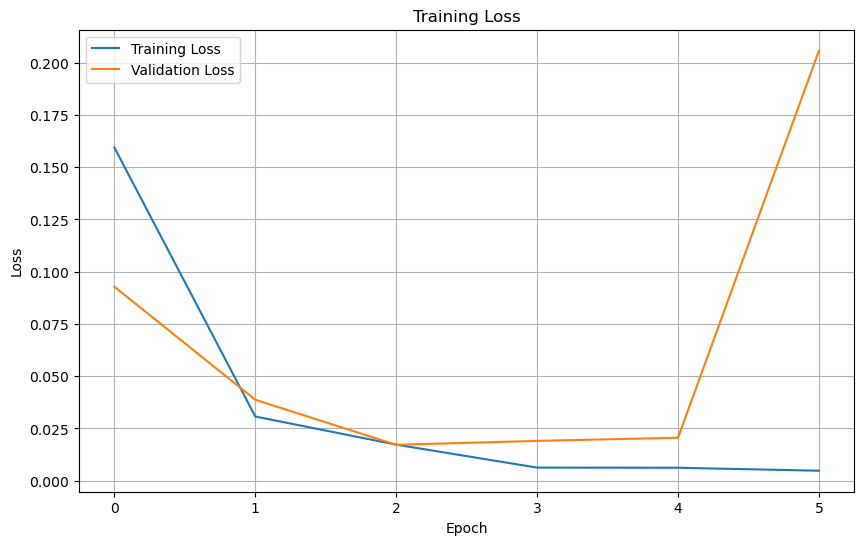

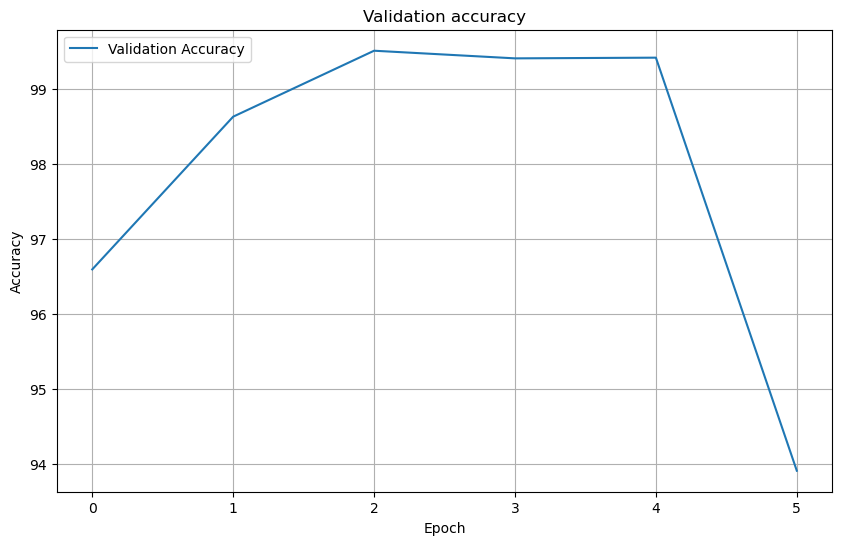

Final Training Accuracy: 98.61%


In [ ]:
# Loss graph
plt.figure(figsize=(10, 6))
plt.plot(epoch_losses, label="Training Loss") # Training loss
plt.plot(val_losses, label="Validation Loss") # Validation loss
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()    
plt.legend()    
plt.grid(True)

count = 1

while (True):
    if (os.path.isfile("../../trained_models/audio_custom_model_" + f"{count}" + ".pth") == False):
        plt.savefig("../../src/audio/graphs/audio_custom_model_" + f"{count - 1}" + "_training_loss.png") # Save the graph
        break
    else:
        count += 1

plt.show()

# Accuracy graph
plt.figure(figsize=(10, 6))
plt.plot(val_accuracies, label="Validation Accuracy") # Validation accuracy
plt.title("Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

count = 1

while (True):
    if (os.path.isfile("../../trained_models/audio_custom_model_" + f"{count}" + ".pth") == False):
        plt.savefig("../../src/audio/graphs/audio_custom_model_" + f"{count - 1}" + "_validation_accuracy.png") # Save the graph
        break
    else:
        count += 1

plt.show()

# Calculate the accuracy for the entire training set
train_accuracy = 100 * sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)

print(f"Final Training Accuracy: {train_accuracy:.2f}%")

In [ ]:
current_model_path = get_current_model_path()

In [ ]:
model = CustomNeuralNetwork(image_height=input_height,
                                        image_width=input_width,
                                        in_channels=num_channels)

In [ ]:
# Load model
model.load_state_dict(torch.load(current_model_path)) # load the trained model
model = model.to(device)

/tmp/ipykernel_46207/3786989068.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(current_model_path)) # load the trained model


In [ ]:
model.eval()

# Initialize lists to store predictions and true labels
all_test_preds = []
all_test_labels = []

# Disable gradient calculations for evaluation
with torch.no_grad():
    # Iterate over the test dataloader
    for data in test_dataloader:
        # Get inputs and labels, and move them to the correct device
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(inputs)

        # Get the predicted class (the one with the highest probability)
        _, predicted = torch.max(outputs, 1)

        # Append the predicted classes and true labels to the lists
        # Move predictions and labels to CPU and convert to numpy arrays for scikit-learn
        all_test_preds.extend(predicted.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

Classification Report on Test Data:
              precision    recall  f1-score   support

        fake       0.74      0.95      0.83      2370
        real       0.93      0.64      0.76      2264

    accuracy                           0.80      4634
   macro avg       0.83      0.80      0.80      4634
weighted avg       0.83      0.80      0.80      4634


Confusion Matrix on Test Data:
[[2253  117]
 [ 804 1460]]


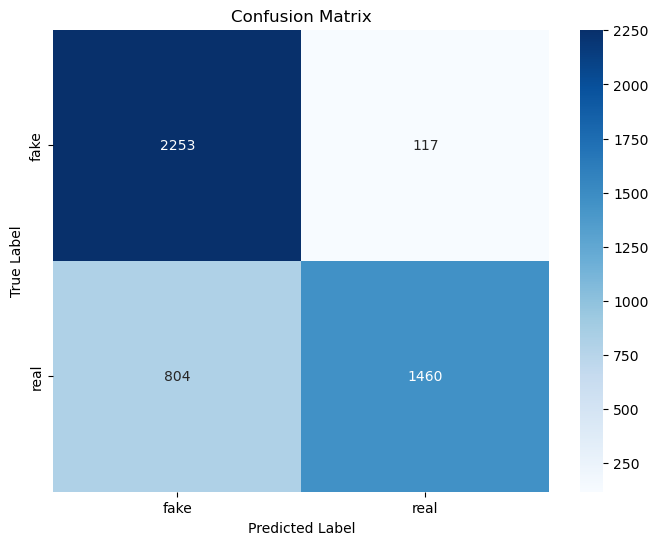

In [ ]:
# Define the class names based on the label encoding used in the dataset (0: fake, 1: real)
target_names = ['fake', 'real']

# Generate and print the classification report
print("Classification Report on Test Data:")
report = classification_report(all_test_labels, all_test_preds, target_names=target_names)
print(report)

# Generate and print the confusion matrix
print("\nConfusion Matrix on Test Data:")
cm = confusion_matrix(all_test_labels, all_test_preds)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()